# Basic use of the `OptimizationResult` object and methods

After familiarizing yourself with the `Monte_Carlo` method from the `Optimizer` class you may seek basic or sophisticated analysis methods of your parameter-to-output dependencies. The `OptimizationResult` object essentially has two major functions:  
**1)** Retrieve and organize all relevant ouput metadata and output simulation data; and  

**2)** Povide a way to compare multiple simulation output based on differenet model performance metrics including giving the user access to the file path locations of relevant model inputs and outputs. 

In [1]:
import sys
sys.path.append('..')
from prms_python import Data, Optimizer, Parameters, util
from prms_python.optimizer import OptimizationResult
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib, json
import warnings; warnings.simplefilter('ignore')
matplotlib.style.use('ggplot')
%matplotlib inline
%load_ext autoreload
%autoreload 2

params = Parameters('../test/data/models/lbcd/parameters')
data = Data('../test/data/models/lbcd/data')
control = '../test/data/models/lbcd/control'
work_directory = '../test/results/'
measrd = '../test/data/fake_measured_swrad_lbcd.csv'

In [2]:
optr = Optimizer(params, data, control, work_directory, title='swrad_norm') 
util.delete_out_files(work_directory, 'prms.out')

stage = 'ddsolrad'
optr.monte_carlo(measrd, ['tmax_index','dday_intcp'], 'swrad_2490', n_sims=16, method='normal', noise_factor=0.2, stage=stage)

['../test/results/tmax_index:54.242612', '../test/results/tmax_index:51.279046', '../test/results/tmax_index:41.466182', '../test/results/tmax_index:42.727247', '../test/results/tmax_index:46.306464', '../test/results/tmax_index:54.784009', '../test/results/tmax_index:47.114773', '../test/results/tmax_index:44.887524', '../test/results/tmax_index:49.591542', '../test/results/tmax_index:50.157562', '../test/results/tmax_index:53.602256', '../test/results/tmax_index:41.372396', '../test/results/tmax_index:41.710526', '../test/results/tmax_index:55.939615', '../test/results/tmax_index:45.193473', '../test/results/tmax_index:50.924395']
--------------------------------------------------------------------------------
Output information sent to ../test/results/swrad_norm_ddsolrad_opt.json



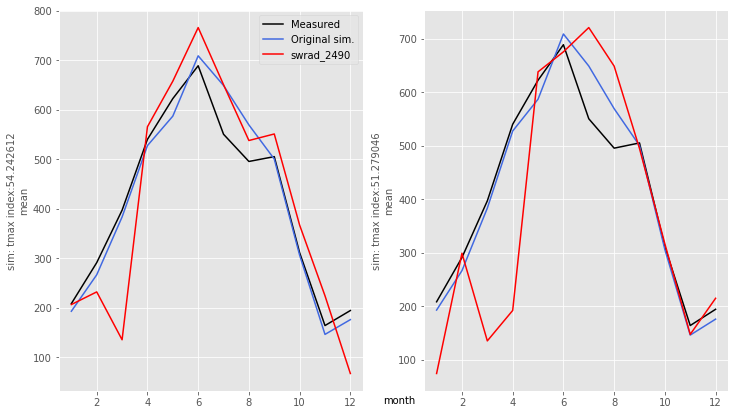

In [3]:
optr.plot_optimization(n_plots=2, freq='monthly', method='time_series')

# `OptimizationResult` attributes

Attributes of the `OptimizationResult` class allow for custom workflows for analysis of Mote Carlo optimization output. In particular they give the user access to the original parameter set and model output, the measured time series of the optimized variable, and paths to all simulations that had parameters modified. 

In [4]:
cust_res = OptimizationResult(work_directory, stage=stage)

In [5]:
# directory of the original simulation's input files
cust_res.input_dir

'../test/data/models/lbcd'

In [6]:
# path to original parameter file
cust_res.input_params

['../test/data/models/lbcd/parameters']

In [7]:
# name of the PRMS statistical variable that is being optimized
cust_res.statvar_name

'swrad_2490'

In [8]:
# the optimization stage, can be named arbitrarily in this case we use the name of the 
# PRMS solar radiation module 
cust_res.stage

'ddsolrad'

In [9]:
# the OptimizationResult.measured attribute holds a Pandas.Series object of the 
# measured variable that is being optimized
cust_res.measured.head()

1937-10-01    447.752204
1937-10-02    441.216580
1937-10-03    410.682145
1937-10-04    176.349945
1937-10-05    126.152800
dtype: float64

In [10]:
# the working_dir is the directory where PRMS-Python will look for Optimizer JSON files
cust_res.working_dir

'../test/results/'

In [11]:
# list of paths to of all metadata JSON files corresponding given optimization stage
cust_res.metadata_json_paths

{'ddsolrad': ['../test/results/swrad_norm_ddsolrad_opt.json']}

The location of each parameter set that was modified in an individual optimization run is stored in the JSON metadata files. More on this can be found in the Jupyter notebook titled "monte_carlo_param_resampling". Below is an example showing how modified parameter sets may be accessed using `OptimizationResult.metadata_json_paths`. Another perhaps more convenient way of accessing parameters along with their outputs based on their output performance is demonstrated later in this notebook.

In [12]:
# get a JSON file path from the list, in this case the first JSON corresponds with the first optimization run
json_path = cust_res.metadata_json_paths[cust_res.stage][0]

fh = open(json_path)
json_data = json.load(fh)
json_data

{'end_time': '2018-06-04 18:05:00',
 'measured': '../test/data/fake_measured_swrad_lbcd.csv',
 'method': 'Monte Carlo',
 'n_sims': 16,
 'noise_factor': 0.2,
 'nproc': 4,
 'optimization_description': None,
 'optimization_title': 'swrad_norm',
 'original_params': '../test/data/models/lbcd/parameters',
 'params_adjusted': ['tmax_index', 'dday_intcp'],
 'resample': 'normal',
 'sim_dirs': ['../test/results/tmax_index:54.242612',
  '../test/results/tmax_index:51.279046',
  '../test/results/tmax_index:41.466182',
  '../test/results/tmax_index:42.727247',
  '../test/results/tmax_index:46.306464',
  '../test/results/tmax_index:54.784009',
  '../test/results/tmax_index:47.114773',
  '../test/results/tmax_index:44.887524',
  '../test/results/tmax_index:49.591542',
  '../test/results/tmax_index:50.157562',
  '../test/results/tmax_index:53.602256',
  '../test/results/tmax_index:41.372396',
  '../test/results/tmax_index:41.710526',
  '../test/results/tmax_index:55.939615',
  '../test/results/tmax_in

As we can see the JSON metadata does not hold information on which simulation performed best. However we can access all stored metadata directly using this method. If the given optimization stage, in this case 'ddsolrad', was created using multiple instances of an Optimizer object then there will be multiple JSON files each with its own information. If for example we wanted to know the method used for resampling from an individual Optimizer run we can use the `.get` method of the JSON dictionary as shown below.

In [13]:
json_data.get('resample') # which param resampling method was used for this Optimizer run 

'normal'

In [14]:
# all simulation directories associated with the given Optimizer run
json_data.get('sim_dirs')

['../test/results/tmax_index:54.242612',
 '../test/results/tmax_index:51.279046',
 '../test/results/tmax_index:41.466182',
 '../test/results/tmax_index:42.727247',
 '../test/results/tmax_index:46.306464',
 '../test/results/tmax_index:54.784009',
 '../test/results/tmax_index:47.114773',
 '../test/results/tmax_index:44.887524',
 '../test/results/tmax_index:49.591542',
 '../test/results/tmax_index:50.157562',
 '../test/results/tmax_index:53.602256',
 '../test/results/tmax_index:41.372396',
 '../test/results/tmax_index:41.710526',
 '../test/results/tmax_index:55.939615',
 '../test/results/tmax_index:45.193473',
 '../test/results/tmax_index:50.924395']

## Run another set of optimizations to add to results

The `OptimizationResult` class gathers model output from an arbitrarily large number of `Optimizer` simulations so long as they share the same optimization stage. In this example we named our stage 'ddsolrad' because we are resampling parameters associated with that solar radiation module in PRMS. The following code demonstrates that additional optimization simulations can be run using different resampling control parameters, e.g. resampling method and number of simulations, and results will added to a new `OptimizationResult` instance. 

In [15]:
# a new Optimizer instance to change the title
optr = Optimizer(params, data, control, work_directory, title='swrad_unif') 
util.delete_out_files(work_directory, 'prms.out')

# keep the same stage name sp that we can add to results, change resample method and n_sims
optr.monte_carlo(measrd, ['tmax_index','dday_intcp'], 'swrad_2490', n_sims=16, method='uniform', stage=stage)

['../test/results/tmax_index:31.678946', '../test/results/tmax_index:50.204322', '../test/results/tmax_index:69.326962', '../test/results/tmax_index:29.226783', '../test/results/tmax_index:56.151262', '../test/results/tmax_index:65.739760', '../test/results/tmax_index:62.919472', '../test/results/tmax_index:44.456071', '../test/results/tmax_index:48.351162', '../test/results/tmax_index:39.700467', '../test/results/tmax_index:54.226247', '../test/results/tmax_index:44.325686', '../test/results/tmax_index:45.924064', '../test/results/tmax_index:58.170364', '../test/results/tmax_index:39.126543', '../test/results/tmax_index:50.141058']
--------------------------------------------------------------------------------
Output information sent to ../test/results/swrad_unif_ddsolrad_opt.json



In [16]:
# create new OptimizationResult instance to view results from both optimizations
ddsolrad_res = OptimizationResult(work_directory, stage=stage)

In [17]:
# we can see that the OptimizationResult includes simulations from both Monte Carlo optimizations
ddsolrad_res.metadata_json_paths

{'ddsolrad': ['../test/results/swrad_norm_ddsolrad_opt.json',
  '../test/results/swrad_unif_ddsolrad_opt.json']}

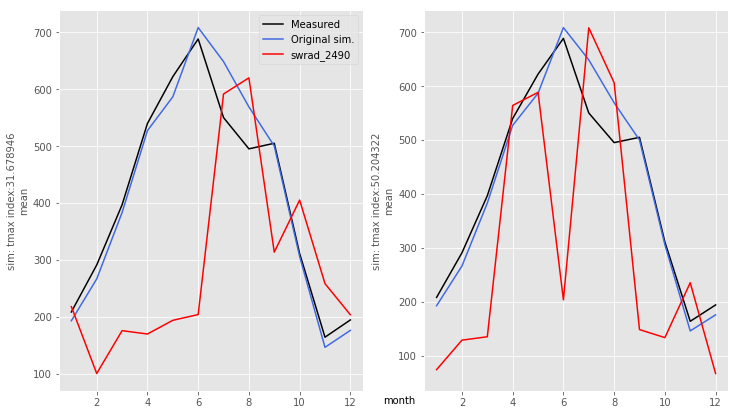

In [18]:
optr.plot_optimization(n_plots=2, freq='monthly', method='time_series')

# Using `OptimizationResult` methods to compare results and access parameter and output sets that correspond with each other.

There are currently two major methods of the `OptimizationResult`. The `.result_table` allows the user to rank simulations using four objective functions on the optimization variable. The `.get_tope_ranked_sims` is used to map input parameters to simulation outputs according to the ranked models. We rank by maximizing the daily or monthly Nash Sutcliffe Efficiency (NSE) and the coefficient of determination (COEF_DET), minimizing root mean squared error (RMSE) and percent bias (PBIAS). 

In [19]:
# note, when using monthly frequency the optimization variable is averaged (mean simulated and mean observed)
top10 = ddsolrad_res.result_table(freq='monthly',top_n=10)
top10

ddsolrad parameters,NSE,RMSE,PBIAS,COEF_DET
tmax_index:42.727247,0.707379,91.993401,-5.226479,0.892980
tmax_index:54.242612,0.664403,98.517339,-0.163458,0.833180
tmax_index:41.466182,0.604059,107.008642,-10.668013,0.836360
tmax_index:45.193473,0.592333,108.581670,-3.143272,0.798430
tmax_index:54.784009,0.573315,111.085559,-5.498206,0.788942
tmax_index:41.372396,0.536930,115.724948,1.157747,0.779254
tmax_index:55.939615,0.527151,116.940597,-11.582918,0.658910
tmax_index:44.456071,0.483787,122.185180,-8.335115,0.692865
tmax_index:50.157562,0.439496,127.319005,-12.249815,0.697202
tmax_index:44.887524,0.438735,127.405419,-7.637637,0.718447


The `result_table` method sorts all simulations by NSE followed by RMSE, PBIAS, and lastly COEF_DET. The index of the dataframe is the name of the simulation which follows the naming convention of the `Optimizer.monte_carlo` method that uses the name of the first parameter that is resampled and it's mean value to six decimals. Because the result is a DataFrame it is possible to resort simulations by any of the columns as opposed to weighting NSE highest. 

---

## Mapping parameters to outputs example
The `OptimizationResult.get_top_ranked_sims` method takes a `Optimization.result_table` and returns a dictionary that includes four lists: the ranked simulation names; the parameter paths for each simulation; the parameters that were adjusted for each simulation (may be a list of parameters if more than one was adjusted); and the stavar file paths for each simulation. In each case these are indexed in the order of the `result_table` that is passed to the function as shown below.

In [20]:
mappnig_dic = ddsolrad_res.get_top_ranked_sims(top10)
mappnig_dic

{'dir_name': ['tmax_index:42.727247',
  'tmax_index:54.242612',
  'tmax_index:41.466182',
  'tmax_index:45.193473',
  'tmax_index:54.784009',
  'tmax_index:41.372396',
  'tmax_index:55.939615',
  'tmax_index:44.456071',
  'tmax_index:50.157562',
  'tmax_index:44.887524'],
 'param_path': ['../test/results/tmax_index:42.727247/inputs/parameters',
  '../test/results/tmax_index:54.242612/inputs/parameters',
  '../test/results/tmax_index:41.466182/inputs/parameters',
  '../test/results/tmax_index:45.193473/inputs/parameters',
  '../test/results/tmax_index:54.784009/inputs/parameters',
  '../test/results/tmax_index:41.372396/inputs/parameters',
  '../test/results/tmax_index:55.939615/inputs/parameters',
  '../test/results/tmax_index:44.456071/inputs/parameters',
  '../test/results/tmax_index:50.157562/inputs/parameters',
  '../test/results/tmax_index:44.887524/inputs/parameters'],
 'params_adjusted': [['tmax_index', 'dday_intcp'],
  ['tmax_index', 'dday_intcp'],
  ['tmax_index', 'dday_intcp'

A common workflow will require analysis of both good results and the parameters that gave such results. 
The `OptimizationResult.get_top_ranked_sims` and `Optimization.result_table` allow for such analysis. Although more sophisticated methods exist and are appropriate in many cases, below we show simple visualization of the top 3 parameter sets for the solar radiation optimization. 

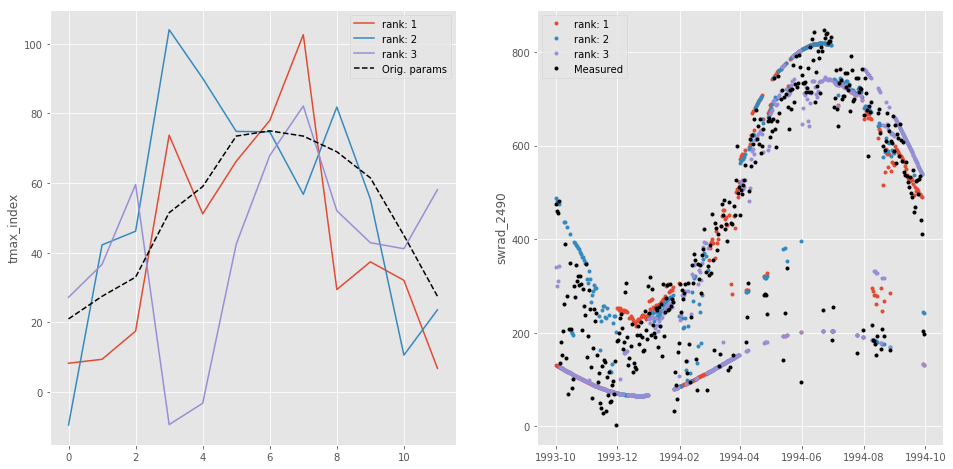

In [21]:
# dates for one year of output on plot
dates = pd.date_range(start='1993-10-01', end='1994-09-30')

fig, axes = plt.subplots(1,2, figsize = (16,8))

for i in range(3):
    rank = i+1
    params = mappnig_dic.get('params_adjusted')[i]
    n_params = len(params)
    param_file = mappnig_dic.get('param_path')[i]
    adj_param = Parameters(param_file)[params[0]]
    axes[0].plot(adj_param, label='rank: {}'.format(rank))
    axes[0].set_ylabel(params[0])

    statvar_file = mappnig_dic.get('statvar_path')[i]      
    statvar = util.load_statvar(statvar_file)[ddsolrad_res.statvar_name]
    axes[1].plot(statvar.loc[dates], '.', label='rank: {}'.format(rank))
    axes[1].set_ylabel(ddsolrad_res.statvar_name)

    
original_param = Parameters(ddsolrad_res.input_params[0])[params[0]]
axes[0].plot(original_param, 'k--', label='Orig. params')    
axes[0].legend()

axes[1].plot(ddsolrad_res.measured.loc[dates], 'k.', label='Measured')    
axes[1].legend()

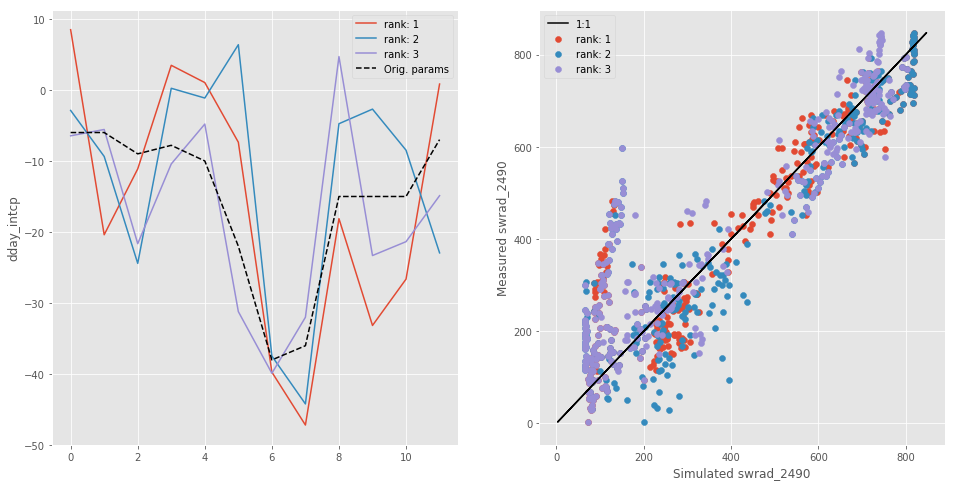

In [22]:
# similar for second parameter adjusted (dday_intcp)
fig, axes = plt.subplots(1,2, figsize = (16,8))

for i in range(3):
    rank = i+1
    params = mappnig_dic.get('params_adjusted')[i]
    n_params = len(params)
    param_file = mappnig_dic.get('param_path')[i]
    adj_param = Parameters(param_file)[params[1]]
    axes[0].plot(adj_param, label='rank: {}'.format(rank))
    axes[0].set_ylabel(params[1])

    statvar_file = mappnig_dic.get('statvar_path')[i]      
    statvar = util.load_statvar(statvar_file)[ddsolrad_res.statvar_name]
    axes[1].scatter(statvar.loc[dates], ddsolrad_res.measured.loc[dates], label='rank: {}'.format(rank))
   
original_param = Parameters(ddsolrad_res.input_params[0])[params[1]]
axes[0].plot(original_param, 'k--', label='Orig. params')    
axes[0].legend()
axes[1].set_ylabel('Measured {}'.format(ddsolrad_res.statvar_name))
axes[1].set_xlabel('Simulated {}'.format(ddsolrad_res.statvar_name))
axes[1].plot(ddsolrad_res.measured.loc[dates], ddsolrad_res.measured.loc[dates], 'k-', label='1:1')    
axes[1].legend()